<a href="https://colab.research.google.com/github/Praveen76/Introduction-to-PyTorch/blob/main/Introduction_to_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives

At the end of the experiment, you will be able to

* understand & build different components of Model Class in PyTorch through a regression example
* understand & build  the train and test loop in PyTorch
* understand & build Customdataset Class in PyTorch
* understand batch processing in PyTorch
* understand & use dataloader in PyTorch

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
# Check PyTorch version
torch.__version__

'2.2.1+cu121'

### Downloading data

In [ ]:
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/data1.txt

#### Understanding and visualizing the data

In [ ]:
df=pd.read_csv('data1.txt',header=None)
df.rename(columns={0:'Population',1:'Profit'},inplace=True)
df.head()

,Population,Profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


Text(0, 0.5, 'Profit of Appolo Pharmacy in 10,000')

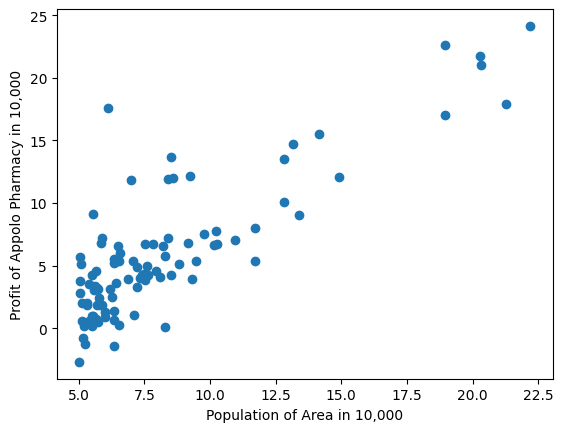

In [ ]:
plt.scatter(df.Population,df.Profit)
plt.xlabel('Population of Area in 10,000')
plt.ylabel('Profit of Appolo Pharmacy in 10,000')

In [ ]:
data,targets=  df.Population.values[:,np.newaxis],df.Profit.values[:,np.newaxis]

### Train-Test Split

In [ ]:
train_data,test_data,train_targets,test_targets=train_test_split(data,targets)

In [ ]:
train_data.shape

(72, 1)

In [ ]:
test_data.shape

(25, 1)

### Setting the GPU

In [ ]:
# Linux bash command to print the status of nvidia gpu (memory and processes)
!nvidia-smi

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda")

### **Class approach for Regression**

In [ ]:
from torch import nn # nn contains all of PyTorch's building blocks for neural networks

In [ ]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module):# <- almost everything in PyTorch is a nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
    # <- start with random weights, get adjusted as the model learns, float32 by default, gradient tracking for GD updates)
    self.bias = nn.Parameter(torch.randn(1,dtype=torch.float), requires_grad=True)

  # Forward defines the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
    return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

Checking the contents of a PyTorch model:

Let's create a model instance with the class we've made and check its parameters using .parameters().



In [ ]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel().to(device) ## Different from Tensorflow

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1288], device='cuda:0', requires_grad=True)]

We can also get the state (what the model contains) of the model using .state_dict().

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367], device='cuda:0')),
             ('bias', tensor([0.1288], device='cuda:0'))])

Making predictions using torch.inference_mode()

To check this we can pass it the test data X_test to see how closely it predicts y_test.

When we pass data to our model, it'll go through the model's forward() method and produce a result using the computation we've defined.

Let's make some predictions.

In [ ]:
test_data[:,0]

array([ 6.3589,  5.1793,  5.5416,  7.6031,  5.5649, 18.959 ,  5.8014,
       11.708 ,  6.5894,  7.6366,  5.2524,  5.3794,  5.0269,  7.5402,
       10.957 ,  5.4369, 22.203 ,  5.4069, 12.836 , 10.274 , 11.7   ,
        8.4084, 20.27  ,  9.1802,  5.0594])

In [ ]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(torch.from_numpy(test_data).to(device)) ## different tensorflow


* **torch.inference_mode()** : Turns off gradient tracking (necessary for training but not for inference) to make forward-passes (data going through the forward() method faster.

* Note: In older PyTorch code, you may also see **torch.no_grad()** being used for inference. While torch.inference_mode() and torch.no_grad() do similar things,
torch.inference_mode() is newer, potentially faster and preferred.

In [ ]:
# Check the predictions
print(f"Number of testing samples: {len(test_data)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 25
Number of predictions made: 25
Predicted values:
tensor([[2.2698],
        [1.8726],
        [1.9946],
        [2.6887],
        [2.0025],
        [6.5121],
        [2.0821],
        [4.0708],
        [2.3474],
        [2.7000],
        [1.8972],
        [1.9400],
        [1.8213],
        [2.6675],
        [3.8179],
        [1.9594],
        [7.6043],
        [1.9493],
        [4.4506],
        [3.5880],
        [4.0681],
        [2.9598],
        [6.9535],
        [3.2197],
        [1.8323]], device='cuda:0', dtype=torch.float64)


### **Train model**

#### Defining loss function and optimizer

In [ ]:
# Create the loss function
loss_fn = nn.MSELoss().to(device) # MSE loss
# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01) # parameters of the model to optimize,  learning rate

#### Train and Test loop

In [ ]:
# Converting data into torch tensor and passing into GPU
X_train=torch.from_numpy(train_data).to(device)
y_train=torch.from_numpy(train_targets).to(device)
X_test=torch.from_numpy(test_data).to(device)
y_test=torch.from_numpy(test_targets).to(device)

In [ ]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 1000

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step() ## Gradient descent eqn: w:=w-(alpha)*(dl/dw), b:=b-(alpha)*(dl/db)


    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().cpu().numpy())
            test_loss_values.append(test_loss.detach().cpu().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 27.38524815272073 | MAE Test Loss: 18.653759261541918 
Epoch: 10 | MAE Train Loss: 11.737504353126331 | MAE Test Loss: 12.06131769393454 
Epoch: 20 | MAE Train Loss: 11.633345477381043 | MAE Test Loss: 11.803733125951585 
Epoch: 30 | MAE Train Loss: 11.535455314641032 | MAE Test Loss: 11.560170489842085 
Epoch: 40 | MAE Train Loss: 11.443450735889607 | MAE Test Loss: 11.329057416297179 
Epoch: 50 | MAE Train Loss: 11.35697786896375 | MAE Test Loss: 11.10971132404905 
Epoch: 60 | MAE Train Loss: 11.275704115975307 | MAE Test Loss: 10.901489748622312 
Epoch: 70 | MAE Train Loss: 11.19931691084865 | MAE Test Loss: 10.703786593701507 
Epoch: 80 | MAE Train Loss: 11.127522404753545 | MAE Test Loss: 10.516030902589048 
Epoch: 90 | MAE Train Loss: 11.06004452070882 | MAE Test Loss: 10.337683195468719 
Epoch: 100 | MAE Train Loss: 10.996623696600935 | MAE Test Loss: 10.168235894949062 
Epoch: 110 | MAE Train Loss: 10.937015905946186 | MAE Test Loss: 10.00720914090347

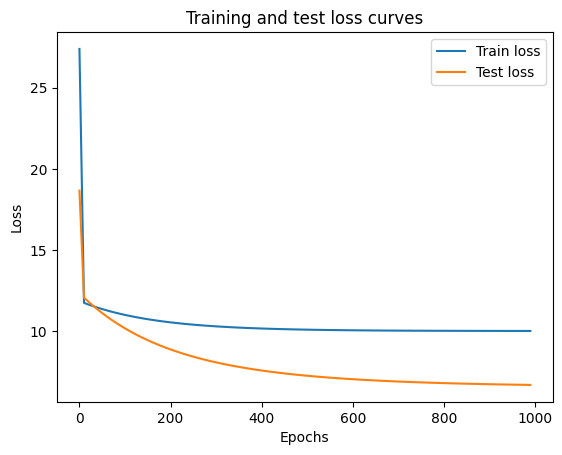

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([1.1447], device='cuda:0')), ('bias', tensor([-3.0987], device='cuda:0'))])


4. Making predictions with a trained PyTorch model (inference)

In [ ]:
X_train=torch.from_numpy(train_data).to(device)
y_train=torch.from_numpy(train_targets).to(device)
X_test=torch.from_numpy(test_data).to(device)
y_test=torch.from_numpy(test_targets).to(device)

In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()
# 2. Setup the inference mode context manager
with torch.inference_mode():
  model_0.to(device)
  y_preds = model_0(X_train)

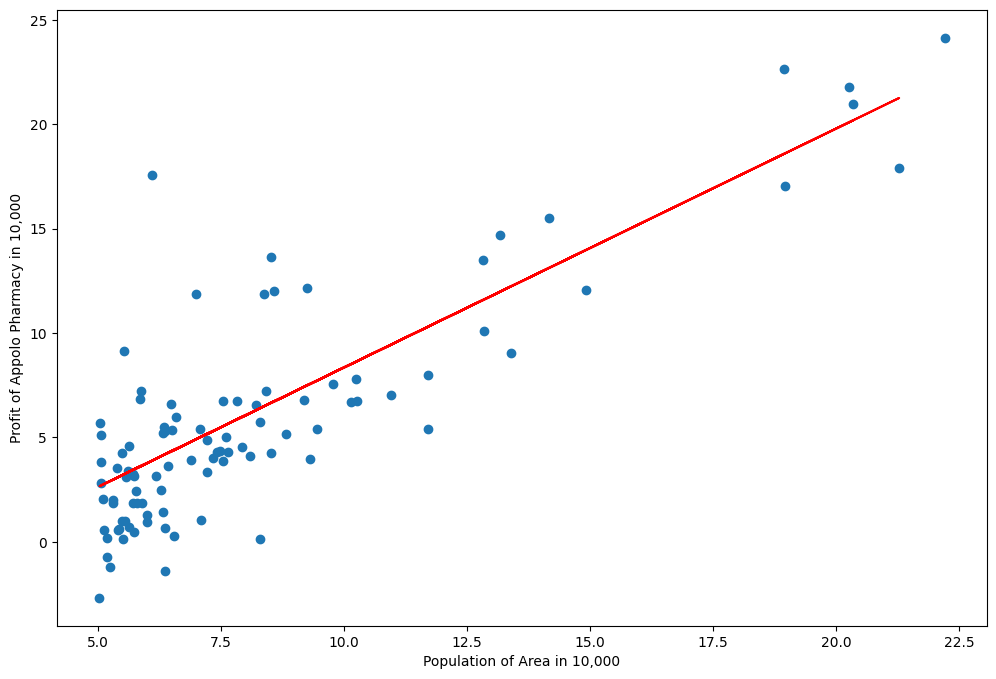

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(df.Population,df.Profit)
plt.xlabel('Population of Area in 10,000')
plt.ylabel('Profit of Appolo Pharmacy in 10,000')
plt.plot(train_data,y_preds.cpu(),'r-')

### CustomDataset class and Batch Processing

### Defining Data_Class called 'CustomDataset' for building our own custom dataset compatible with dataloader.

In [ ]:
alist=[1,2,3,4,5,6,7,8,9]
print(alist)
len(alist)

[1, 2, 3, 4, 5, 6, 7, 8, 9]


9

In [ ]:
alist[2:4] # slicing operation [ ]

[3, 4]

In [ ]:
alist[3]

4

In [ ]:
class CustomDataset:

  def __init__(self,data,targets):
    self.data=data
    self.targets=targets

  def __len__(self):
     return self.data.shape[0] #len(self.data)

  def __getitem__(self,idx):
    sliced_sample=self.data[idx,:]
    sliced_target=self.targets[idx]
    return {"sample" :torch.tensor(sliced_sample, dtype=torch.float),
            "target" : torch.tensor(sliced_target, dtype=torch.float)
            }

### Testing of Above Data Class

In [ ]:
df.Population.values[:,np.newaxis]

In [ ]:
data,targets=  df.Population.values[:,np.newaxis],df.Profit.values[:,np.newaxis]

In [ ]:
data.shape

(97, 1)

In [ ]:
data[0]

array([6.1101])

In [ ]:
targets[0]

array([17.592])

In [ ]:
custom_dataset  = CustomDataset (data=data, targets=targets)

In [ ]:
len(custom_dataset)

In [ ]:
custom_dataset[0]

{'sample': tensor([6.1101]), 'target': tensor([17.5920])}

In [ ]:
custom_dataset[[0,1,2]]

{'sample': tensor([[6.1101],
         [5.5277],
         [8.5186]]),
 'target': tensor([[17.5920],
         [ 9.1302],
         [13.6620]])}

In [ ]:
custom_dataset[0]['sample'].shape

In [ ]:
custom_dataset[0]['target']

In [ ]:
for idx in range(len(custom_dataset)):
  print(custom_dataset[idx])
  if idx >5:
    break

{'sample': tensor([6.1101]), 'target': tensor([17.5920])}
{'sample': tensor([5.5277]), 'target': tensor([9.1302])}
{'sample': tensor([8.5186]), 'target': tensor([13.6620])}
{'sample': tensor([7.0032]), 'target': tensor([11.8540])}
{'sample': tensor([5.8598]), 'target': tensor([6.8233])}
{'sample': tensor([8.3829]), 'target': tensor([11.8860])}
{'sample': tensor([7.4764]), 'target': tensor([4.3483])}


### Train-Test Split

In [ ]:
train_data,test_data,train_targets,test_targets=train_test_split(data,targets)

In [ ]:
train_data.shape

(72, 1)

In [ ]:
test_data.shape

(25, 1)

### Making train and test data by using CustomDataset class

In [ ]:
train_dataset = CustomDataset(train_data,train_targets)

test_dataset = CustomDataset(test_data,test_targets)

### Data Loader

We will use same data class and dataset created previously .

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=12,num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=25,num_workers=2)

In [ ]:
train_loader

In [ ]:
for data in train_loader:
  print(data["sample"].shape)
  print(data["target"].shape)
  print(data)

### **Model**

In [ ]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module):# <- almost everything in PyTorch is a nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
    # <- start with random weights, get adjusted as the model learns, float32 by default, gradient tracking for GD updates)
    self.bias = nn.Parameter(torch.randn(1,dtype=torch.float), requires_grad=True)

  # Forward defines the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
    return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

Checking the contents of a PyTorch model:

Let's create a model instance with the class we've made and check its parameters using .parameters().



In [ ]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_1 = LinearRegressionModel().to(device)

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_1.parameters())

[Parameter containing:
 tensor([0.3367], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1288], device='cuda:0', requires_grad=True)]

We can also get the state (what the model contains) of the model using .state_dict().

In [ ]:
# List named parameters
model_1.state_dict()

OrderedDict([('weights', tensor([0.3367], device='cuda:0')),
             ('bias', tensor([0.1288], device='cuda:0'))])

Making predictions using torch.inference_mode()

To check this we can pass it the test data X_test to see how closely it predicts y_test.

When we pass data to our model, it'll go through the model's forward() method and produce a result using the computation we've defined.

Let's make some predictions.

In [ ]:
xtest=[data['sample'] for data in test_loader]

In [ ]:
xtest

In [ ]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_1(xtest[0].to(device))

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_1(xtest)

* **torch.inference_mode()** : Turns off gradient tracking (necessary for training but not for inference) to make forward-passes (data going through the forward() method faster.

* Note: In older PyTorch code, you may also see **torch.no_grad()** being used for inference. While torch.inference_mode() and torch.no_grad() do similar things,
torch.inference_mode() is newer, potentially faster and preferred.

In [ ]:
# Check the predictions
print(f"Number of testing samples: {len(xtest[0])}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 25
Number of predictions made: 25
Predicted values:
tensor([[2.1125],
        [6.5121],
        [2.7000],
        [2.1054],
        [2.4461],
        [1.8359],
        [3.2197],
        [2.2936],
        [1.9773],
        [2.2413],
        [3.5880],
        [2.2610],
        [2.6284],
        [6.9535],
        [2.3127],
        [3.0170],
        [1.8246],
        [1.8323],
        [4.0681],
        [2.1496],
        [2.5170],
        [3.1002],
        [2.2587],
        [2.6460],
        [3.5415]], device='cuda:0')


### **Train model**

#### Defining loss function and optimizer

In [ ]:
# Create the loss function
loss_fn = nn.MSELoss().to(device) # MSE loss
# Create the optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01) # parameters of the model to optimize,  learning rate

#### Train and Test loop

In [ ]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 300

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_1.train()

    # 1. Forward pass on train data using the forward() method inside
    for batch_idx, data in enumerate(train_loader):
      xtrain, ytrain = data["sample"].to(device), data["target"].to(device)
      y_pred = model_1(xtrain)
      # print(y_pred)
      # 2. Calculate the loss (how different are our models predictions to the ground truth)
      loss = loss_fn(y_pred, ytrain)
      loss=loss+loss.item()
      # 3. Zero grad of the optimizer
      optimizer.zero_grad()
      # 4. Loss backwards
      loss.backward()
      # 5. Progress the optimizer
      optimizer.step()

      ### Testing

      # Put the model in evaluation mode
      model_1.eval()

      with torch.inference_mode():
        # 1. Forward pass on test data
        for batch_idx, data in enumerate(test_loader):
          xtest, ytest = data["sample"].to(device), data["target"].to(device)
          test_pred = model_1(xtest)

          # 2. Caculate loss on test data
          test_loss = loss_fn(test_pred, ytest.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type
          test_loss=test_loss+test_loss.item()
        test_loss=test_loss/len(test_loader)
    loss=loss/len(train_loader)
    # Print out what's happening
    if epoch % 10 == 0:
          epoch_count.append(epoch)
          train_loss_values.append(loss.detach().cpu().numpy())
          test_loss_values.append(test_loss.detach().cpu().numpy())
          print(f"Epoch: {epoch} | Train Loss: {loss} | Test Loss: {test_loss} ")

Epoch: 0 | Train Loss: 5.2134833335876465 | Test Loss: 14.52547550201416 
Epoch: 10 | Train Loss: 4.578910827636719 | Test Loss: 12.60631275177002 
Epoch: 20 | Train Loss: 4.043347358703613 | Test Loss: 11.2243013381958 
Epoch: 30 | Train Loss: 3.71992564201355 | Test Loss: 10.500580787658691 
Epoch: 40 | Train Loss: 3.523608684539795 | Test Loss: 10.145025253295898 
Epoch: 50 | Train Loss: 3.403686046600342 | Test Loss: 9.990763664245605 
Epoch: 60 | Train Loss: 3.3298587799072266 | Test Loss: 9.94279670715332 
Epoch: 70 | Train Loss: 3.283982753753662 | Test Loss: 9.9478120803833 
Epoch: 80 | Train Loss: 3.255160331726074 | Test Loss: 9.976527214050293 
Epoch: 90 | Train Loss: 3.236820936203003 | Test Loss: 10.013360977172852 
Epoch: 100 | Train Loss: 3.224982738494873 | Test Loss: 10.050442695617676 
Epoch: 110 | Train Loss: 3.2172203063964844 | Test Loss: 10.084158897399902 
Epoch: 120 | Train Loss: 3.2120461463928223 | Test Loss: 10.113180160522461 
Epoch: 130 | Train Loss: 3.2085

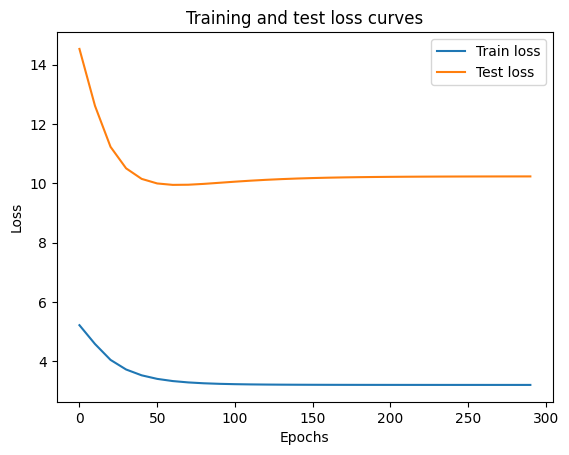

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([1.1447], device='cuda:0')), ('bias', tensor([-3.0987], device='cuda:0'))])


#### Making predictions with a trained PyTorch model (inference)

In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()
y_pred=[]
y_gt=[]

# 2. Setup the inference mode context manager
with torch.inference_mode():
  model_0.to(device)
  for data in train_loader:
    xtrain=data['sample']
    ytrain=data['target']

    y_preds = model_0(xtrain.to(device))
    y_gt.append(ytrain)
    y_pred.append(y_preds )

In [ ]:
Y_pred= torch.cat(y_pred).view(-1)
Y_label= torch.cat(y_gt).view(-1)

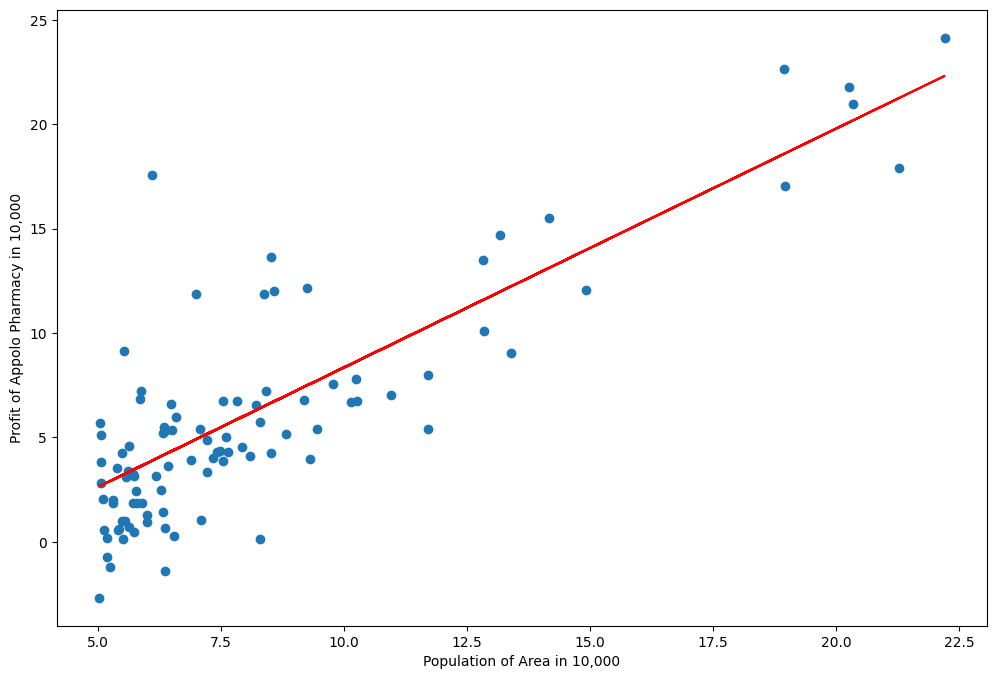

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(df.Population,df.Profit)
plt.xlabel('Population of Area in 10,000')
plt.ylabel('Profit of Appolo Pharmacy in 10,000')
plt.plot(train_data,Y_pred.cpu(),'r-')